# Dissect models

In [ ]:
import sys
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

In [2]:
from ocpmodels.common.flags import flags
from ocpmodels.common.utils import build_config, resolve, setup_imports, merge_dicts
from ocpmodels.trainers.single_trainer import SingleTrainer

In [3]:
runs_dir = "$SCRATCH/ocp/runs"

def load_checkpoint(job_id):
    path = resolve(runs_dir) / job_id

    checkpoint = path / "checkpoints" / "best_checkpoint.pt"
    setup_imports()
    argv = deepcopy(sys.argv)
    # trainer_args = flags.parser.parse_args()
    trainer_args = flags.parser.parse_args([])
    sys.argv[1:] = argv
    trainer_args.continue_from_dir = str(path)
    config = build_config(trainer_args, [])
    config["logger"] = "dummy"
    config["checkpoint"] = str(checkpoint)
    config["optim"]["batch_size"] = 1
    config["optim"]["eval_batch_size"] = 1
    print(config)

    trainer = SingleTrainer(**config)
    
    return trainer


In [4]:
def plot_activations_ewald(model_name, ewald_activation, base_activation):
    ewald_values = []
    for key, value in ewald_activation.items():
        if "EwaldBlock" in key:
            print(value[0].shape)
            value = value[0].cpu().numpy().mean(axis=0)
            ewald_values.append(value.reshape(1, -1))
    ewald_values = np.concatenate(ewald_values, axis=0)
    plt.plot(ewald_values.mean(0), label="Ewald")

    interaction_values = []
    for key, value in ewald_activation.items():
        if "InteractionBlock" in key:
            value = value.cpu().numpy().mean(axis=0)
            interaction_values.append(value.reshape(1, -1))
    interaction_values = np.concatenate(interaction_values, axis=0)
    plt.plot(interaction_values.mean(0), label="Interaction")
    plt.legend()
    plt.xlabel("Hidden dimension")
    plt.ylabel("Activation")
    plt.title(f"{model_name} - Activations for the model with Ewald")
    plt.show()


    base_interaction_values = []
    for key, value in base_activation.items():
        if "InteractionBlock" in key:
            value = value.cpu().numpy().mean(axis=0)
            base_interaction_values.append(value.reshape(1, -1))
    base_interaction_values = np.concatenate(base_interaction_values, axis=0)
    plt.plot(base_interaction_values.mean(0), label="Base model: Interaction")
    plt.plot(interaction_values.mean(0) + ewald_values.mean(0), label="Ewald model: Ewald + Interaction")
    # plt.plot(interaction_values.mean(0), label="Ewald model: Interaction")
    plt.xlabel("Hidden dimension")
    plt.ylabel("Activation")
    plt.title(f"{model_name} - Activations for the model with Ewald")
    plt.legend()
    plt.show()

In [5]:
def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [6]:
def get_activations_ewald(ewald_trainer, base_trainer, model_name="FAENet"):
    loader = base_trainer.get_dataloader(ewald_trainer.datasets["train"], ewald_trainer.samplers["train"])

    ewald_activation = {}
    base_activation = {}

    try:
        for i, block in enumerate(ewald_trainer.model.module.interaction_blocks):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))
    except:
        for i, block in enumerate(ewald_trainer.model.module.interactions):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))
    for i, block in enumerate(ewald_trainer.model.module.ewald_blocks):
        block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))

    try:
        for i, block in enumerate(base_trainer.model.module.interaction_blocks):
            block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation))
    except:
        for i, block in enumerate(base_trainer.model.module.interactions):
                block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation))

    with torch.no_grad():
        ewald_output = ewald_trainer.model_forward(next(iter(loader)))
        base_output = base_trainer.model_forward(next(iter(loader)))

    plot_activations_ewald(model_name, ewald_activation, base_activation)

    return ewald_activation, base_activation


In [18]:
#Loading models:

# # Using 10k splits

# with tag0
job_id_ewald = "4115830" #faenet
job_id = "4115721" # faenet
ewald_trainer_faenet_with_tag0 = load_checkpoint(job_id_ewald)
base_trainer_faenet_with_tag0 = load_checkpoint(job_id)
loader_faenet_with_tag0 = base_trainer_faenet_with_tag0.get_dataloader(ewald_trainer_faenet_with_tag0.datasets["train"], ewald_trainer_faenet_with_tag0.samplers["train"])

# without tag0
job_id_ewald = "4115566" #faenet
job_id = "4115585" # faenet
ewald_trainer_faenet_without_tag0 = load_checkpoint(job_id_ewald)
base_trainer_faenet_without_tag0 = load_checkpoint(job_id)
loader_faenet_without_tag0 = base_trainer_faenet_without_tag0.get_dataloader(ewald_trainer_faenet_without_tag0.datasets["train"], ewald_trainer_faenet_without_tag0.samplers["train"])

# with tag0
job_id_ewald = "4115145" # schnet
job_id = "4115118" #schnet

ewald_trainer_schnet_with_tag0 = load_checkpoint(job_id_ewald)
base_trainer_schnet_with_tag0 = load_checkpoint(job_id)
loader_schnet_with_tag0 = base_trainer_schnet_with_tag0.get_dataloader(ewald_trainer_schnet_with_tag0.datasets["train"], ewald_trainer_schnet_with_tag0.samplers["train"])

# remove tag 0
job_id_ewald = "4115884" # schnet
job_id = "4115115" #schnet

ewald_trainer_schnet_without_tag0 = load_checkpoint(job_id_ewald)
base_trainer_schnet_without_tag0 = load_checkpoint(job_id)
loader_schnet_without_tag0 = base_trainer_schnet_without_tag0.get_dataloader(ewald_trainer_schnet_without_tag0.datasets["train"], ewald_trainer_schnet_without_tag0.samplers["train"])

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4115830/checkpoints/checkpoint-0001580.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

torch.Size([40, 384])
torch.Size([40, 384])
torch.Size([40, 384])
torch.Size([40, 384])
torch.Size([40, 384])


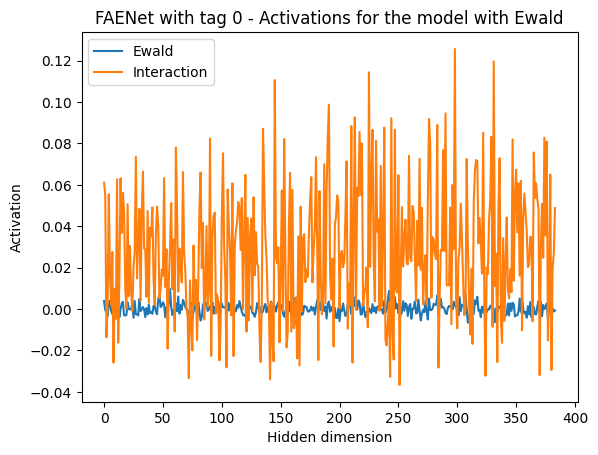

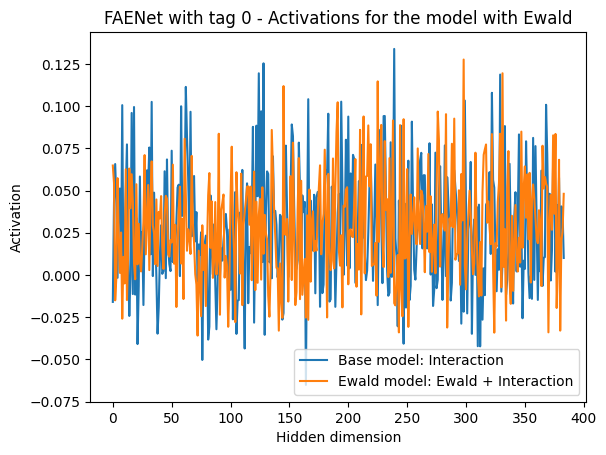

torch.Size([17, 384])
torch.Size([17, 384])
torch.Size([17, 384])
torch.Size([17, 384])
torch.Size([17, 384])


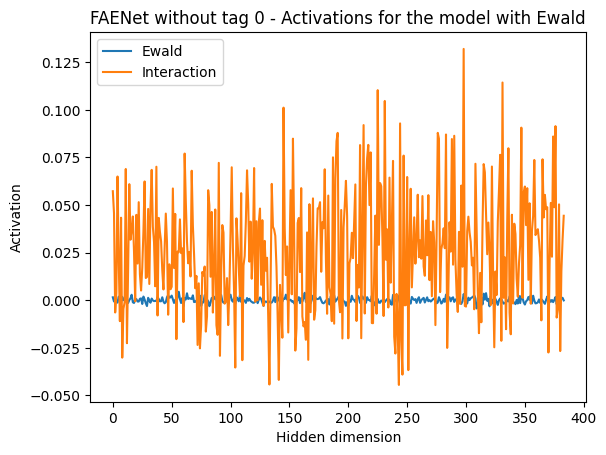

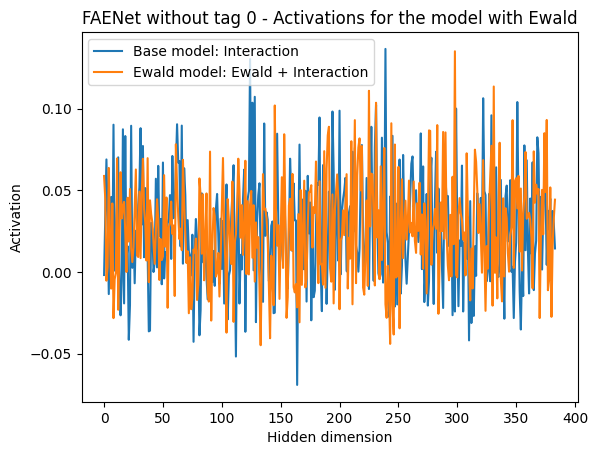

torch.Size([40, 256])
torch.Size([40, 256])
torch.Size([40, 256])


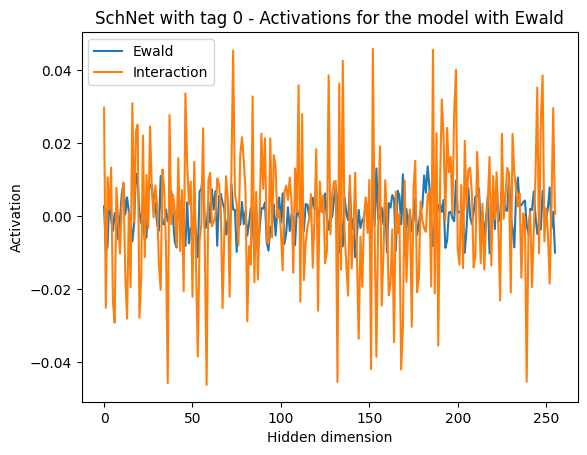

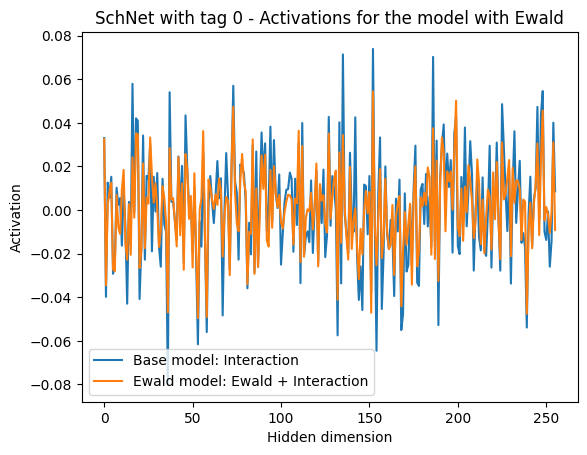

torch.Size([17, 256])
torch.Size([17, 256])
torch.Size([17, 256])


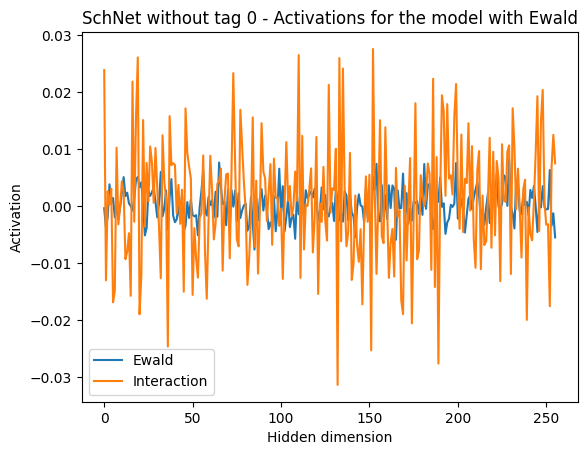

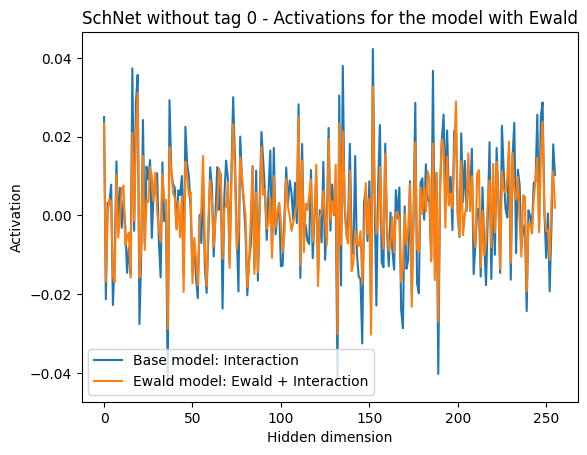

In [8]:
ewald_activation_faenet_with_tag0, base_activation_faenet_with_tag0 = get_activations_ewald(ewald_trainer_faenet_with_tag0, base_trainer_faenet_with_tag0, model_name="FAENet with tag 0")
ewald_activation_faenet_without_tag0, base_activation_faenet_without_tag0 = get_activations_ewald(ewald_trainer_faenet_without_tag0, base_trainer_faenet_without_tag0, model_name="FAENet without tag 0")

ewald_activation_schnet_with_tag0, base_activation_schnet_with_tag0 = get_activations_ewald(ewald_trainer_schnet_with_tag0, base_trainer_schnet_with_tag0, model_name="SchNet with tag 0")
ewald_activation_schnet_without_tag0, base_activation_schnet_without_tag0 = get_activations_ewald(ewald_trainer_schnet_without_tag0, base_trainer_schnet_without_tag0, model_name="SchNet without tag 0")

In [19]:
x = next(iter(loader_schnet_with_tag0))
print(x[0].tags)

x = next(iter(loader_schnet_without_tag0))
print(x[0].tags)

tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])


In [20]:
from ocpmodels.common.utils import conditional_grad, get_pbc_distances
from ocpmodels.datasets.lmdb_dataset import data_list_collater
import torch_geometric
import torch.nn as nn

class GaussianSmearing(nn.Module):
    r"""Smears a distance distribution by a Gaussian function."""

    def __init__(self, start=0.0, stop=5.0, num_gaussians=50):
        super().__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item() ** 2
        self.register_buffer("offset", offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

# Gaussian Basis
distance_expansion = GaussianSmearing(0.0, ewald_trainer_faenet_without_tag0.model.module.cutoff, ewald_trainer_faenet_without_tag0.model.module.num_gaussians)

def process_datapoint(data):
    # data = data_list_collater([x]) # if input is just a single graph rather than a batch

    # Rewire the graph
    z = data.atomic_numbers.long()
    pos = data.pos
    # batch = data.batch
    # batch_size = int(batch.max()) + 1
    energy_skip_co = []


    # if self.dropout_edge > 0:
    #     edge_index, edge_mask = dropout_edge(
    #         data.edge_index,
    #         p=self.dropout_edge,
    #         force_undirected=True,
    #         training=self.training or self.deup_inference,
    #     )

    out = get_pbc_distances(
        pos,
        data.edge_index,
        data.cell,
        data.cell_offsets,
        data.neighbors,
        return_distance_vec=True,
    )

    edge_index = out["edge_index"]
    edge_weight = out["distances"]
    rel_pos = out["distance_vec"]
    edge_attr = distance_expansion(edge_weight)

    new_data = torch_geometric.data.Data(
        x=z,
        pos=rel_pos,
        # batch=batch,
        edge_index=edge_index,
        edge_attr=edge_attr,
        cell=data.cell,
        cell_offsets=data.cell_offsets,
        neighbors=data.neighbors,
        distance_vec=rel_pos,
        energy_skip_co=energy_skip_co,
        tags=data.tags,
        force=data.force,
    )

    return new_data

In [21]:
x = next(iter(loader_schnet_with_tag0))[0]

x, x.tags
#tag 1: Cataclyst surface
#tag 0: Catalyst subsurface
#tag 2: adsorbate

(DataBatch(edge_index=[2, 1372], pos=[40, 3], cell=[1, 3, 3], atomic_numbers=[40], natoms=[1], cell_offsets=[1372, 3], force=[40, 3], distances=[1372], fixed=[40], sid=[1], tags=[40], y_init=[1], y_relaxed=[1], pos_relaxed=[40, 3], id=[1], load_time=[1], transform_time=[1], total_get_time=[1], idx_in_dataset=[1], batch=[40], ptr=[2], neighbors=[1]),
 tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
         0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2]))

In [12]:
x_processed = process_datapoint(x)
x_processed

Data(x=[40], edge_index=[2, 1372], edge_attr=[1372, 104], pos=[1372, 3], cell=[1, 3, 3], cell_offsets=[1372, 3], neighbors=[1], distance_vec=[1372, 3], energy_skip_co=[0], tags=[40], force=[40, 3])

In [13]:
from torch_geometric.utils import to_networkx
import networkx as nx

def oc20_to_graph(x, processed=True):
    #Undirected graph
    if not processed:
        return to_networkx(x, node_attrs=["pos", "tags", "force"], edge_attrs=["cell_offsets"], to_undirected=True)
    return to_networkx(x, node_attrs=["pos", "tags", "x", "force"], edge_attrs=["distance_vec", "cell_offsets"], to_undirected=True)

data_graph = oc20_to_graph(x_processed)

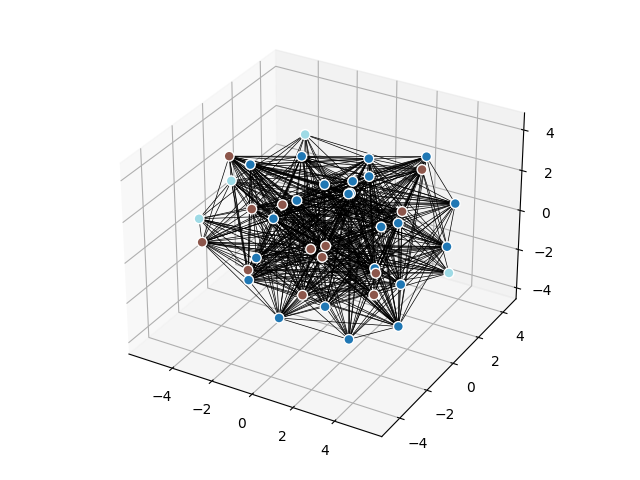

In [14]:
# plot undirected graph
import matplotlib.pyplot as plt
%matplotlib widget

#Extract positions of nodes from node attributes:
def plot_element_3d(data_graph):
    pos = nx.get_node_attributes(data_graph, "pos")
    tags = np.array(list(nx.get_node_attributes(data_graph, "tags").values()))
    # use tags for coloring
    node_xyz = np.array([pos[i] for i in range(len(pos))])
    edge_xyz = np.array([[pos[i], pos[j]] for i, j in data_graph.edges()])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*node_xyz.T, s=50, ec='w', c=tags, cmap='tab20', alpha=1)

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, c='k', lw=0.5)

    fig.tight_layout()
    plt.show()

plot_element_3d(data_graph)

In [15]:
from tqdm import tqdm
# Diameter of the graph

non_connected_graphs_faenet = []
diameters_faenet = []
# Averaged over 1000 graphs
for i, x in tqdm(enumerate(loader_faenet_without_tag0)) :
    processed_x = process_datapoint(x[0])
    data_graph = oc20_to_graph(processed_x)
    if not(nx.is_connected(data_graph)):
        non_connected_graphs_faenet.append(i)
    else:
        diameters_faenet.append(nx.diameter(data_graph))
    if i > 1000:
        break

print(f"no tag 0 Number of non-connected graphs: {len(non_connected_graphs_faenet)}")
print(f"no tag 0 Average diameter: {np.mean(diameters_faenet)}")

non_connected_graphs = []
diameters = []
# Averaged over 1000 graphs
for i, x in tqdm(enumerate(loader_faenet_with_tag0)) :
    processed_x = process_datapoint(x[0])
    data_graph = oc20_to_graph(processed_x)
    if not(nx.is_connected(data_graph)):
        non_connected_graphs.append(i)
    else:
        diameters.append(nx.diameter(data_graph))
    if i > 1000:
        break

print(f"Number of non-connected graphs: {len(non_connected_graphs)}")
print(f"Average diameter: {np.mean(diameters)}")

1001it [00:37, 26.52it/s]

no tag 0 Number of non-connected graphs: 13
no tag 0 Average diameter: 2.1961577350859454



1001it [01:14, 13.40it/s]

Number of non-connected graphs: 10
Average diameter: 3.1340725806451615


base


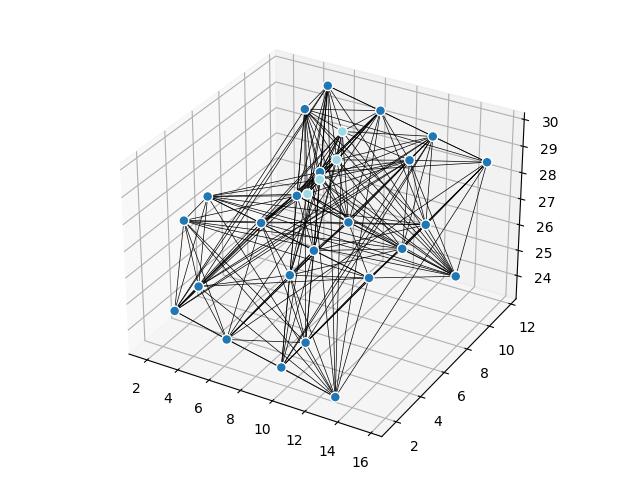

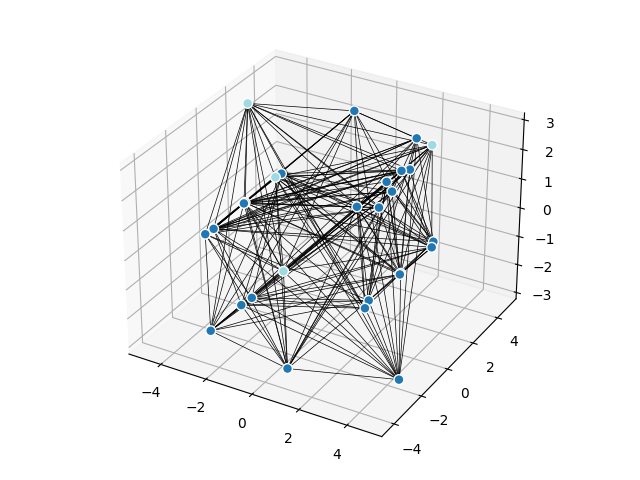

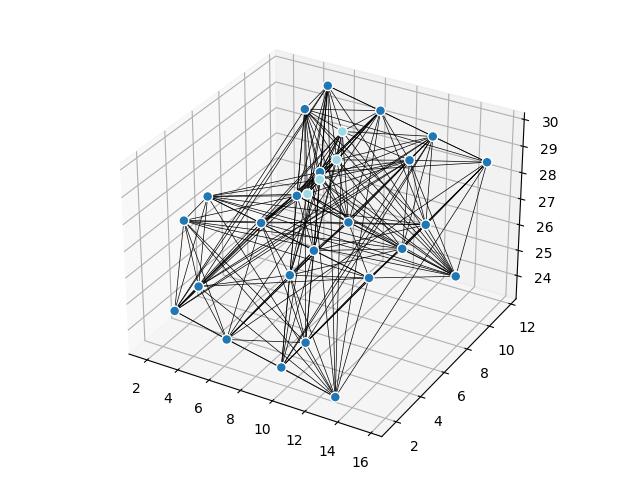

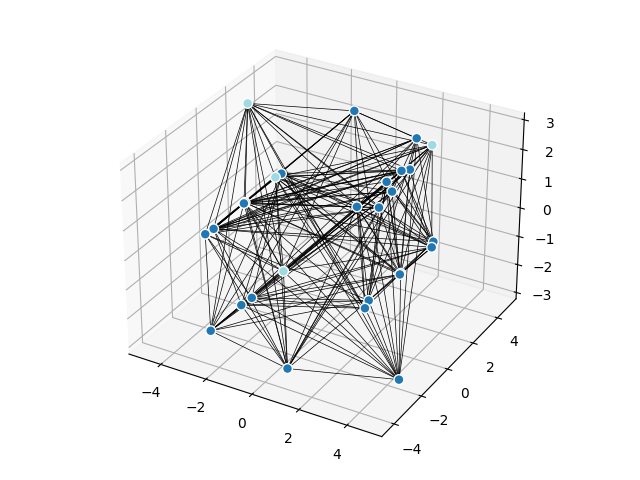

In [23]:
# Look at how information is being passed through the graph:
%matplotlib widget

print(base_trainer_faenet_without_tag0.model.module.mp_type)

base_activation_faenet = {}

base_trainer_faenet_without_tag0.model.module.embed_block.register_forward_hook(get_activation(f"{base_trainer_faenet_without_tag0.model.module.embed_block.__class__.__name__}", base_activation_faenet))

for i, block in enumerate(base_trainer_faenet_without_tag0.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation_faenet))

with torch.no_grad():
    i = 20
    for i, x in enumerate(loader_faenet_without_tag0):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0])
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = base_trainer_faenet_without_tag0.model_forward(x)


base_activation_schnet = {}

base_trainer_schnet_without_tag0.model.module.embedding.register_forward_hook(get_activation(f"{base_trainer_schnet_without_tag0.model.module.embedding.__class__.__name__}", base_activation_schnet))

for i, block in enumerate(base_trainer_schnet_without_tag0.model.module.interactions):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation_schnet))

def get_random_datapoint(loader):
    n = np.random.randint(0, len(loader))
    # Load a random datapoint


with torch.no_grad():
    i = 20
    for i, x in enumerate(loader_schnet_without_tag0):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0])
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = base_trainer_schnet_without_tag0.model_forward(x)


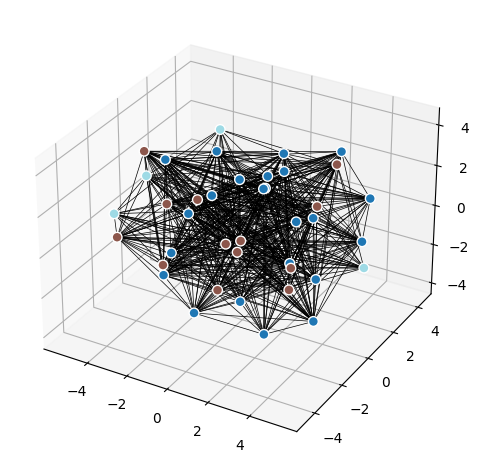

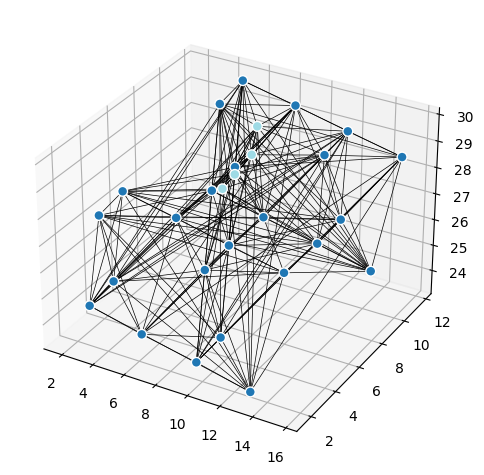

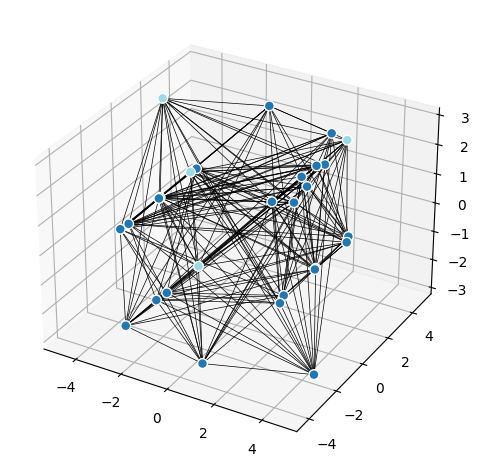

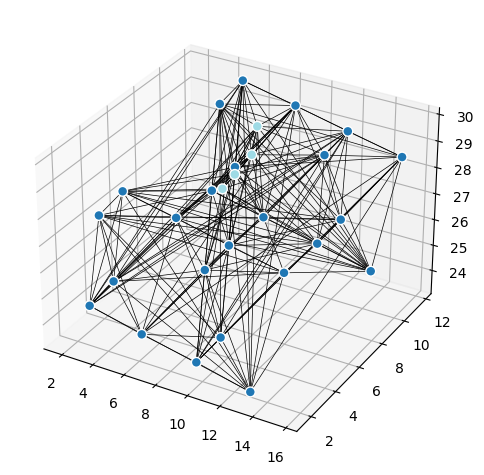

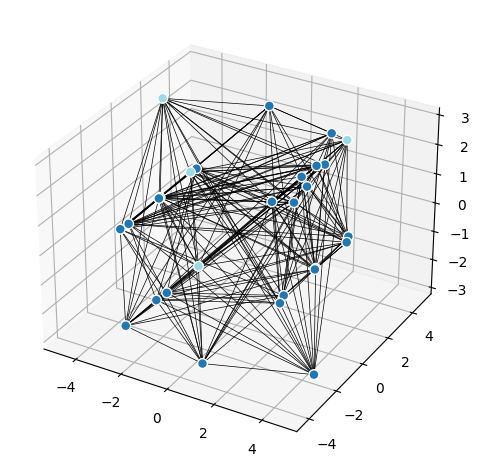

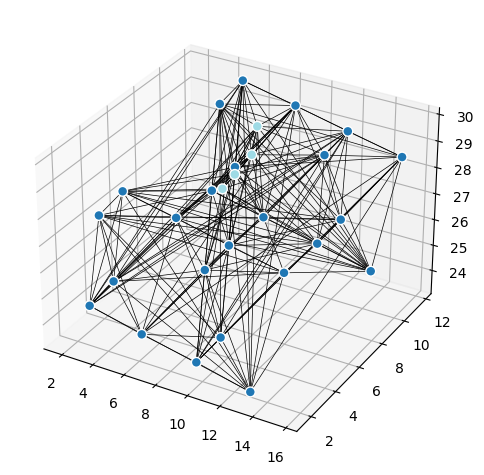

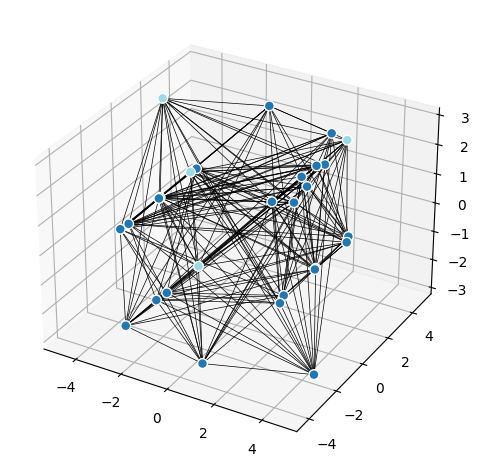

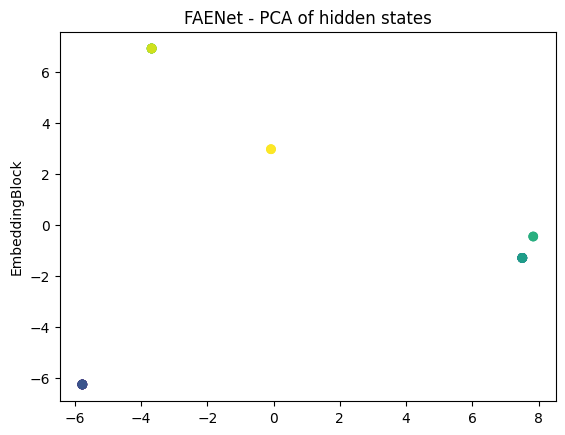

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

plt.rc("animation", html="html5")

def plot_pca(model_name, base_activation):
    key = "InteractionBlock_0"
    h = base_activation[key].cpu().numpy()

    fig, ax = plt.subplots()

    pca = PCA(n_components=2)
    pca.fit(h)
    h_pca = pca.transform(h)
    ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))
    ax.set_title(f"{model_name} - PCA of hidden states")
    ax.set_ylabel(f"{key}")

    def update(key):
        if "EmbeddingBlock" in key: #only for faenet
            h = base_activation[key][0].cpu().numpy()
        else:
            h = base_activation[key].cpu().numpy()

        pca = PCA(n_components=2)
        pca.fit(h)
        h_pca = pca.transform(h)
        ax.clear()
        ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))   
        ax.set_title(f"{model_name} - PCA of hidden states")
        ax.set_ylabel(f"{key}")

        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)

    return ani

ani = plot_pca("FAENet", base_activation_faenet)
ani

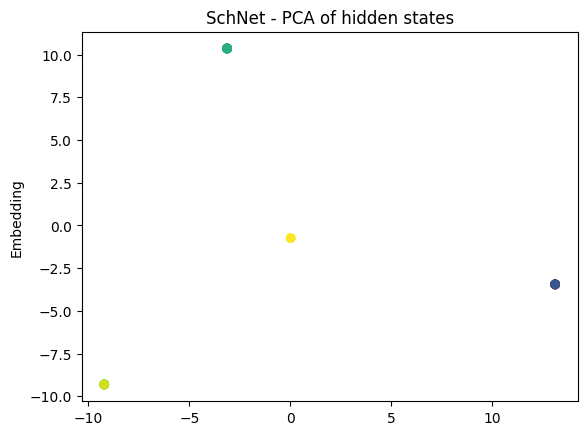

In [25]:
ani = plot_pca("SchNet", base_activation_schnet)
ani

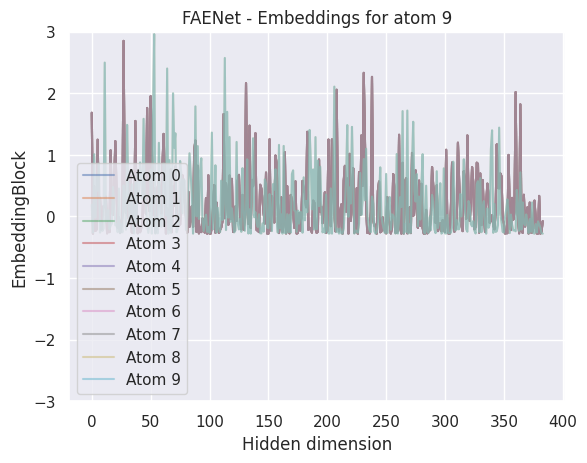

In [33]:
%matplotlib inline

plt.rc("animation", html="html5")

# compare the embeddings of the same atom in different blocks
def plot_embeddings(model_name, base_activation):
    fig, ax = plt.subplots()

    for i in range(min(10, base_activation["InteractionBlock_0"].shape[0])):
        ax.plot(base_activation["InteractionBlock_0"][i, :].cpu().numpy(), label=f"Atom {i}", alpha=0.5)
    ax.set_xlabel("Hidden dimension")
    ax.set_ylabel("Activation")
    ax.set_title(f"{model_name} - Embeddings for atom {i}")
    ax.set(ylim=(-2, 2))
    ax.legend()

    def update(key):
        if key == "EmbeddingBlock":
            h = base_activation[key][0].cpu().numpy()
        else:
            h = base_activation[key].cpu().numpy()
        ax.clear()
        for i in range(min(10, h.shape[0])):
            ax.plot(h[i, :], label=f"Atom {i}", alpha=0.5)
        ax.set_xlabel("Hidden dimension")
        ax.set_ylabel(f"{key}")
        ax.set_title(f"{model_name} - Embeddings for atom {i}")
        ax.set(ylim=(-3, 3))
        ax.legend()
        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)
    return ani

ani = plot_embeddings("FAENet", base_activation_faenet)
ani

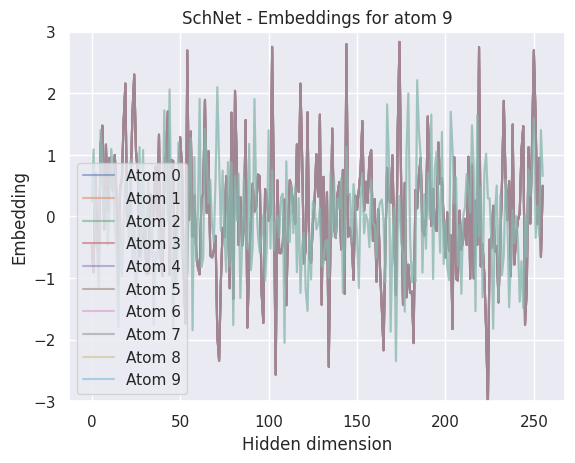

In [34]:
ani = plot_embeddings("SchNet", base_activation_schnet)
#Plot with multiple atoms / transparent / same color over interaction blocks
#Variance of the embeddings
ani

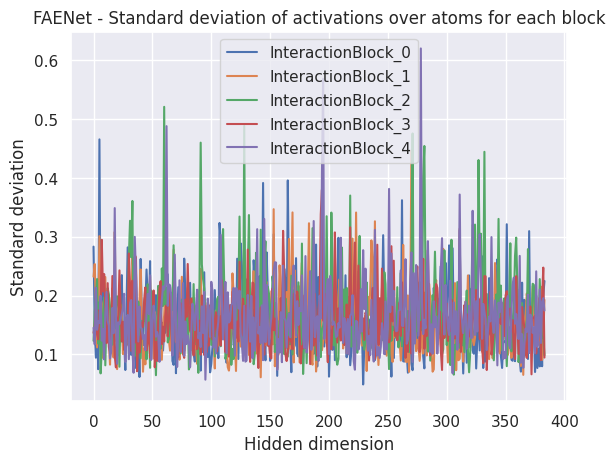

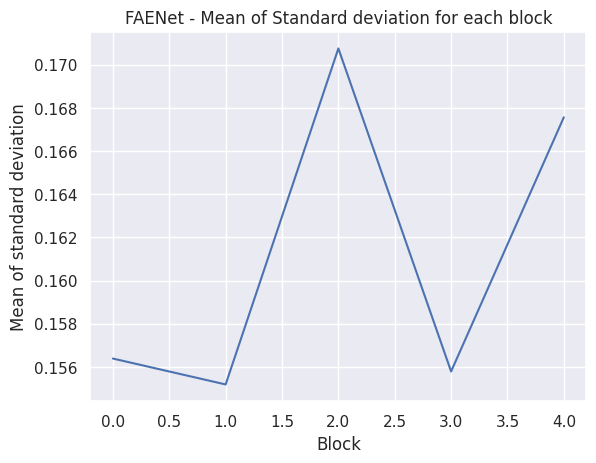

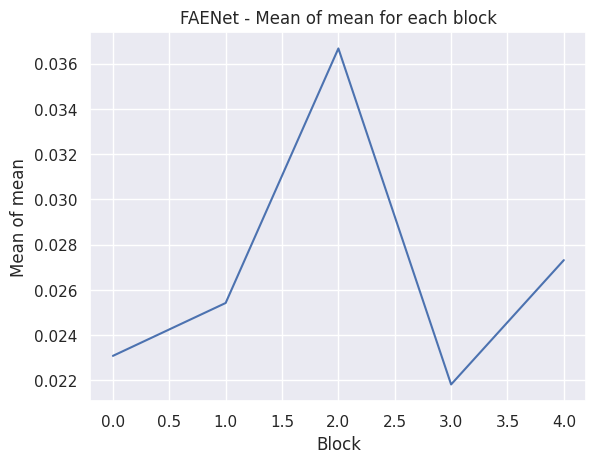

In [43]:
standard_deviations = []
means = []

for block, activations in base_activation_faenet.items():
    if "Embedding" not in block:
        plt.plot(activations.std(0).cpu().numpy(), label=block)
        standard_deviations.append(activations.std(0).mean().cpu().numpy())
        means.append(activations.mean(0).mean().cpu().numpy())
plt.legend()
plt.title("FAENet - Standard deviation of activations over atoms for each block")
plt.xlabel("Hidden dimension")
plt.ylabel("Standard deviation")
plt.show()

plt.plot(standard_deviations)
plt.title("FAENet - Mean of Standard deviation for each block")
plt.xlabel("Block")
plt.ylabel("Mean of standard deviation")
plt.show()

plt.plot(means)
plt.title("FAENet - Mean of mean for each block")
plt.xlabel("Block")
plt.ylabel("Mean of mean")
plt.show()

[[ 0.07056606  0.01968039  0.02006552  0.06120044  0.02071794  0.00715534
   0.02071791  0.06051298  0.08930129  0.08929533  0.14580894  0.1438961
   0.08930127  0.14066735  0.08930124  0.12428552  0.05822234  0.031296
  -0.02900248 -0.04447955  0.03842537 -0.00939148 -0.02798491  0.05433515
   0.01572033 -0.01419693  0.19526748  0.2156372 ]
 [ 0.07056606  0.01968039  0.02006552  0.06120044  0.02071794  0.00715534
   0.02071791  0.06051298  0.08930129  0.08929533  0.14580894  0.1438961
   0.08930127  0.14066735  0.08930124  0.12428552  0.05822234  0.031296
  -0.02900248 -0.04447955  0.03842537 -0.00939148 -0.02798491  0.05433515
   0.01572033 -0.01419693  0.19526748  0.2156372 ]
 [ 0.07056606  0.01968039  0.02006552  0.06120044  0.02071794  0.00715534
   0.02071791  0.06051298  0.08930129  0.08929533  0.14580894  0.1438961
   0.08930127  0.14066735  0.08930124  0.12428552  0.05822234  0.031296
  -0.02900248 -0.04447955  0.03842537 -0.00939148 -0.02798491  0.05433515
   0.01572033 -0.01

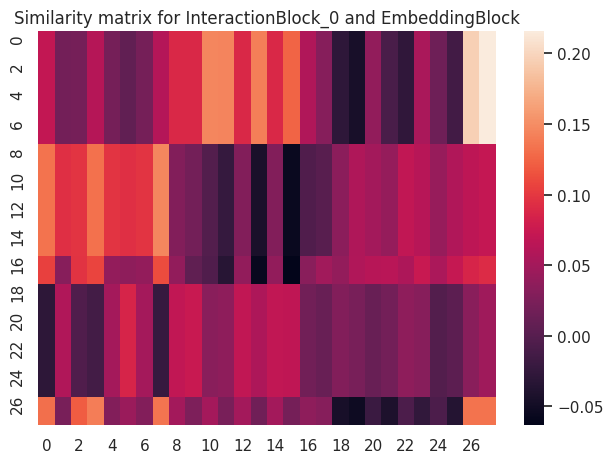

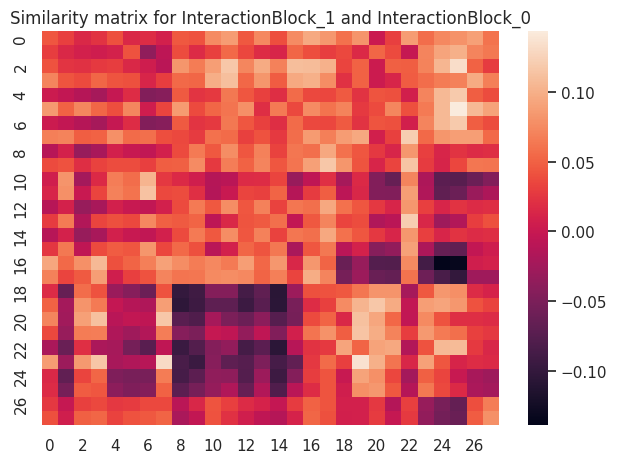

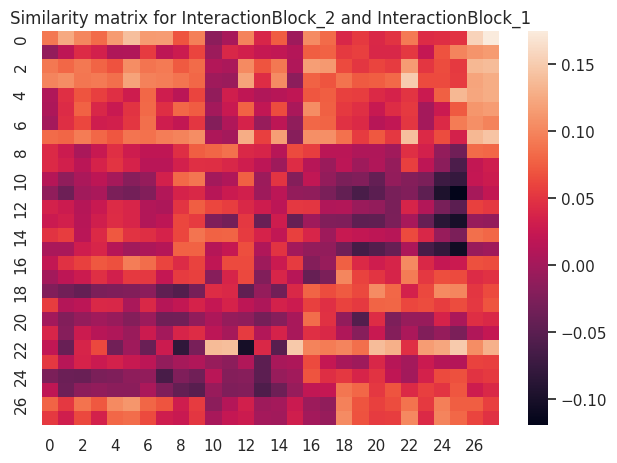

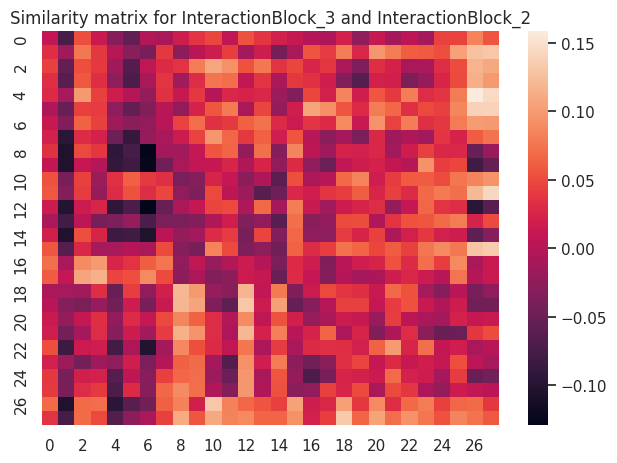

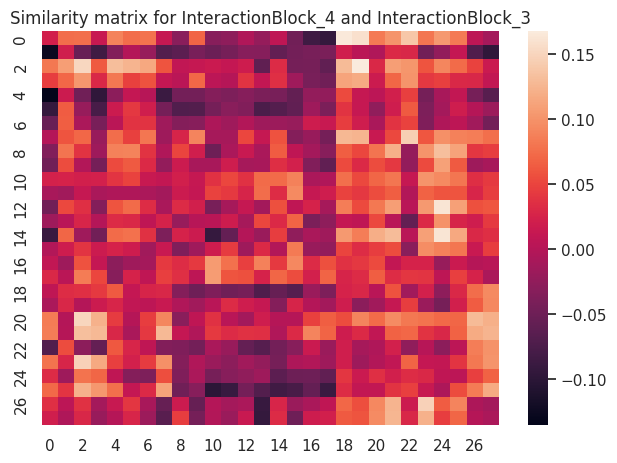

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn

seaborn.set_theme()

h_prev = base_activation_faenet["EmbeddingBlock"][0].cpu().numpy()
key_prev = "EmbeddingBlock"
for key, embedding_step in base_activation_faenet.items():
    if "EmbeddingBlock" in key:
        continue
    h = embedding_step.cpu().numpy()

    cosine_similarity_matrix = cosine_similarity(h_prev, h)
    fig, ax = plt.subplots()
    ax.set_title(f"Similarity matrix for {key} and {key_prev}")
    seaborn.heatmap(cosine_similarity_matrix, ax=ax)
    fig.tight_layout()
    fig.show()
    print(cosine_similarity_matrix)

    h_prev = h
    key_prev = key

    
